### 3D Volume Reconstruction and Rotation Parameter Recovery of Gaussian Blobs with Oscillating Rotation Around a Main Axis

In [1]:
import sys
sys.path.append('..')

import tomodpdt

import numpy as np
import time
import matplotlib.pyplot as plt

import deeplay as dl

import torch
from torch.utils.data import DataLoader

In [2]:
DEV = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', DEV)

Using device: cuda


In [3]:
plotly_3d = False # Do interactive 3D plots with plotly
save_folder = None # Save the results to a folder

if save_folder is not None:
    import os
    os.makedirs(save_folder, exist_ok=True)

## 1 - Import 3D Volume Data

In this example, we load a 3D volume consisting of small Gaussian blobs placed randomly within the volume. The original volume is 64x64x64 voxels in size, but it can be upsampled or downsampled to any desired resolution.


In [4]:
volume = tomodpdt.VOL_GAUSS_MULT

In [5]:
print(f"Shape of the volume: {volume.shape}")

Shape of the volume: (64, 64, 64)


the 3D volume is stored in a numpy array and can be interactively visualized using the ipyvolume library...

In [6]:
# Visualize the volume in 3D space - needs plotly and ipywidgets
if plotly_3d:
    tomodpdt.plotting.visualize_3d_volume(volume)

or with sum projections along the x, y, and z axes...

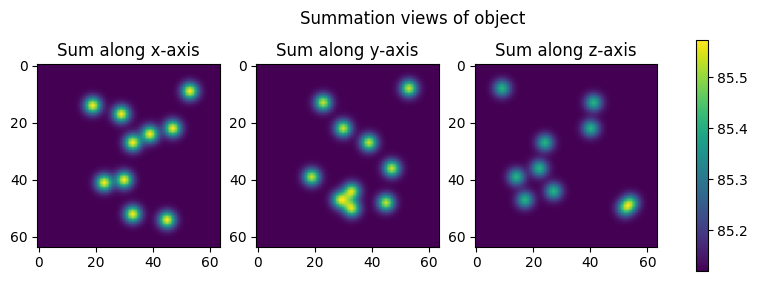

In [7]:
tomodpdt.plotting.plot_sum_object(volume)

## 2 - Choosing the Imaging Modality

The next step is to choose the imaging modality, which defines the function that transforms the 3D volume into a 2D image. In this notebook, we use the simplest imaging modalities, which are sum projections along the x, y, or z axes.

There are two main types of imaging modalities available:

- **`Sum3d2d`**: Computes the sum of pixel values along a specified axis.
- **`SumAvgWeighted3d2d`**: Computes the sum of pixel values along an axis, with each pixel weighted by its distance from the top of the volume.

In [8]:
from tomodpdt.imaging_modality_torch import Sum3d2d #,SumAvgWeighted3d2d,

# Define the model and which axis to sum over
sum_model = Sum3d2d(dim=-1)

### 2.1 Generating Training Data

We begin by generating the dataset that will be used to train the model. For this tutorial, we use the **`Sum3d2d`** imaging modality in combination with the 3D volume data to create our training samples.

The data generation is handled by a function where you can customize the following parameters:

- **`rotation_case`** — Defines the type of rotation applied. In this example, we use `'random_sinosoidal'`, meaning:
  - The rotation follows a sinusoidal pattern.
  - The rotation axis is chosen randomly.
- **`samples`** — Specifies how many data samples to generate.
- **`duration`** — Indicates the number of full rotations to perform.

The function returns:

-  `test_object`: The object being projected  
-  `quaternions`: Ground truth rotation parameters  
-  `projections`: Forward projections (here, sums along the z-axis)  
-  `imaging_model`: The imaging modality used (`Sum3d2d` in this case)


In [9]:
test_object, q_gt, projections, imaging_model = tomodpdt.simulate.create_data(
    volume=volume, # The volume we want to reconstruct
    image_modality=sum_model, # We use the sum model
    rotation_case='random_sinusoidal', # We rotate the object around 1 main axis, but the other 2 axes are also non-zero an
    samples=400, # Number of projections
    duration=2 # Duration is the number of full revolutions
    )

Simulating... 25.0%
Simulating... 50.0%
Simulating... 75.0%


As a quick sanity check, we can inspect the shapes of the generated components to ensure everything looks correct:

-  **3D Object Shape** — Represents the volume of the object
-  **Rotation Parameters (Quaternions)** — Ground truth rotations applied to the object
-  **Projections** — Forward projections of the object along the z-axis
-  **Imaging Model** — The imaging modality used for the projections


These shapes should match your expectations based on the number of samples and the structure of the input volume.

In [10]:
print(f"Shape of the test_object: {test_object.shape}")
print(f"Shape of the q_gt: {q_gt.shape}")
print(f"Shape of the projections: {projections.shape}")
print(f"Type of imaging_model: {type(imaging_model)}")

Shape of the test_object: torch.Size([64, 64, 64])
Shape of the q_gt: torch.Size([400, 4])
Shape of the projections: torch.Size([400, 1, 64, 64])
Type of imaging_model: <class 'tomodpdt.imaging_modality_torch.Sum3d2d'>


### 2.2 Visualizing the Training Data

In this section, we explore the generated training data through projection images and their corresponding rotation parameters.

#### Projecting the 3D Object

To get a better sense of the data, we visualize a random **3×3 grid** of sample projections. This gives us a quick qualitative feel for the diversity and appearance of the generated data.

Each image represents a 2D projection of the 3D object, created using the **`Sum3d2d`** imaging modality.

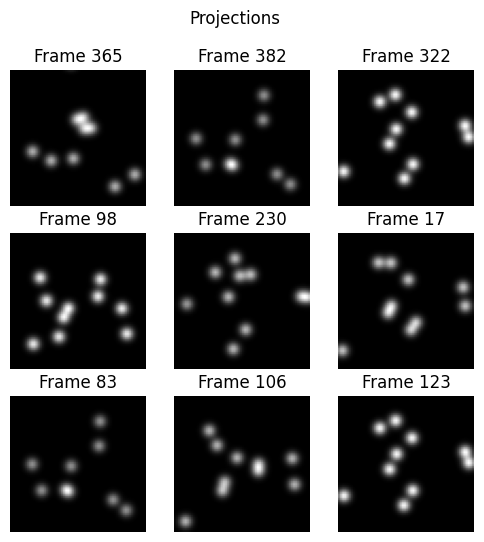

In [11]:
tomodpdt.plotting.plot_grid33_frames(projections, title="Projections", randomize=True)

####  Visualizing the Quaternion Trajectory

Now that we've seen a sample of the projections, let's look at the **quaternions**.

Each projection is generated by applying a 3D rotation to the volume, and that rotation is encoded as a **quaternion** — a compact, four-dimensional vector that represents rotation in 3D space.

---

##### What Are Quaternions?

Quaternions are commonly used in 3D graphics and robotics for representing rotations. Compared to other representations like Euler angles or rotation matrices, they offer several advantages:

-  No gimbal lock (a common issue with Euler angles)
-  Smooth interpolation between orientations
-  Compact and efficient (just 4 values: \([q_w, q_x, q_y, q_z]\))

In our data, each quaternion corresponds to the exact rotation used to create its associated projection. In this case we have 400 samples, each with a quaternion representing the rotation applied to the 3D volume.


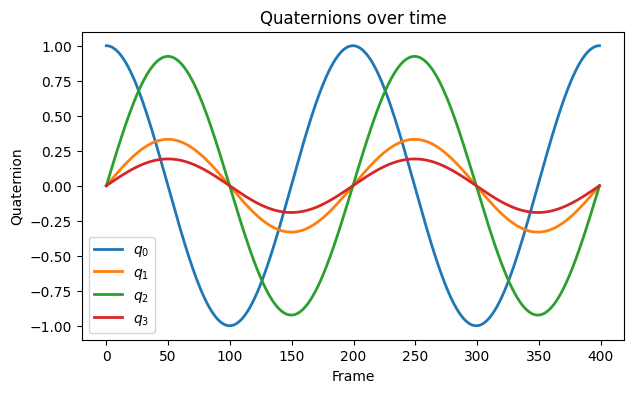

In [12]:
tomodpdt.plotting.plot_quaternions(q_gt)

## 3 - Tomographic Reconstruction

In this step, we focus on **tomographic reconstruction**—the process of reconstructing a 3D volume from a series of 2D images. This notebook implements a fundamental reconstruction technique: **backprojection with Stochastic Gradient Descent (SGD).**

Unlike traditional methods, our approach does not assume prior knowledge of the 3D volume or the rotation parameters, which adds a layer of complexity to the problem. The reconstruction process is divided into two key steps:


#### **Step 1: Estimating Initial Rotation Parameters**

- A **Variational Autoencoder (VAE)** is trained on the 2D images to learn a compact latent representation and reconstruct the images.

- Using this learned latent representation, we estimate the initial rotation parameters that best correspond to the image orientations.


#### **Step 2: Optimizing the 3D Volume and Rotation Parameters**

- **Stochastic Gradient Descent (SGD)** is employed to iteratively refine both the 3D volume and the associated rotation parameters.

- The optimization process is driven by a composite loss function, which incorporates the following components:

  - **Projection Loss (Proj loss)**: Measures the mean absolute error between the original 2D images and their corresponding forward projections from the current 3D volume.

  - **Latent Loss**: Captures the Euclidean distance between the latent space embeddings of the original and projected images.

  - **Total Variation Loss (Rtv loss)**: Applies a smoothness constraint to the 3D volume, encouraging spatial continuity and reducing noise.

  - **Quaternion Validity Loss (Qv loss)**: Ensures the rotation parameters remain valid quaternions by penalizing deviations from unit norm (i.e., the squared norm should equal 1).

  - **Initial Quaternion Loss (Q0 loss)**: Encourages the initial quaternion values to start at \([1, 0, 0, 0]\), representing no rotation.

  - **Rotation Smoothness Loss (Rtr loss)**: Promotes temporal or sequential smoothness in the rotation parameters, ensuring gradual transitions.

  - **Strictly Over Loss (So loss)**: Enforces a minimum threshold for certain voxel values. This is particularly useful for image modalities that assume physical constraints, such as a refractive index being strictly greater than 1.


### 3.1 - Set Up the Tomographic Reconstruction Class

The `Tomography` class serves as the core component for handling the tomographic reconstruction process. It is implemented as a `dl.Application` module, which facilitates seamless training and inference workflows.

The class is initialized with several parameters that define the reconstruction process. Here are the key parameters you can customize first:

- **`volume_size`**: The size of the 3D volume, assumed to be cubic. This is defined by the shape of the `volume`, which dictates the resolution of the final reconstruction.
  
- **`initial_volume`**: We initialize the volume with a basic assumption, here set to `'refraction'`, because we are optimizing for the refractive index. This can be adjusted depending on the imaging modality. In essence, this is the initial guess for the 3D volume as constant (1.33 for refraction and 0 otherwise).

- **`rotation_optim_case`**: Specifies the method used to optimize the rotation parameters. `'basis'` ensures smoother transitions, while `'quaternion'` focuses on more precise, quaternion-based rotations.

- **`imaging_model`**: Refers to the specific imaging model used in this reconstruction. Here, we use the `sum_model`, which represents the projection summing along a particular axis.



In [ ]:
# Set the size of the volume, we assume it is a cube.
N=volume.shape[0]

# Create the tomographic_model
tomographic_model = tomodpdt.Tomography(
    volume_size=(N, N, N), # The size of the volume
    initial_volume='refraction', # 'refraction' since we are optimizing the refractive index
    rotation_optim_case='basis', # 'basis' or 'quaternion', 'basis' is smoother
    imaging_model=sum_model, # The imaging model
    )

### 3.2 - Initialize the Rotation Parameters

As discussed earlier, the rotation parameters are initialized using a **Variational Autoencoder (VAE)**. The `initialize_parameters` method estimates these initial rotation parameters by first training the VAE on the 2D images. 

The VAE learns a compact latent representation of the images, and from this, we can identify the corresponding rotation parameters. Specifically, we locate the **peaks in latent space** — areas where the points are closest to each other, representing the orientations of the images within the rotation space. Worth mentioning is that we use scipy's `find_peaks` function to identify these peaks, which in some instances may need some tuning to ensure that the peaks are correctly identified.

This process provides an effective initialization for the rotation parameters, setting a solid foundation for the later optimization steps.

In [ ]:
# Initialize the parameters
tomographic_model.initialize_parameters(projections, normalize=True)

c:\Users\Fredrik\miniconda3\envs\pytorchdt\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


┏━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name                ┃ Type                 ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ encoder             │ Sequential           │ 79.5 K │
│ 1 │ fc_mu               │ MultiLayerPerceptron │ 32.8 K │
│ 2 │ fc_var              │ MultiLayerPerceptron │ 32.8 K │
│ 3 │ fc_dec              │ MultiLayerPerceptron │ 51.3 K │
│ 4 │ decoder             │ Sequential           │ 61.0 K │
│ 5 │ reconstruction_loss │ BCELoss              │      0 │
│ 6 │ train_metrics       │ MetricCollection     │      0 │
│ 7 │ val_metrics         │ MetricCollection     │      0 │
│ 8 │ test_metrics        │ MetricCollection     │      0 │
│ 9 │ optimizer           │ Adam                 │      0 │
└───┴─────────────────────┴──────────────────────┴────────┘

Trainable params: 257 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 257 K                                                                                                
Total estimated model params size (MB): 1

c:\Users\Fredrik\miniconda3\envs\pytorchdt\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

c:\Users\Fredrik\miniconda3\envs\pytorchdt\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\Fredrik\miniconda3\envs\pytorchdt\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (13) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


and visualize the initial rotation parameters...

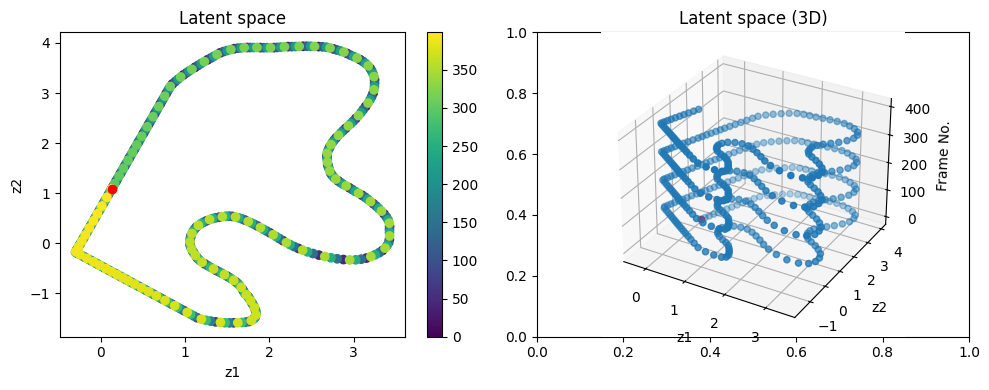

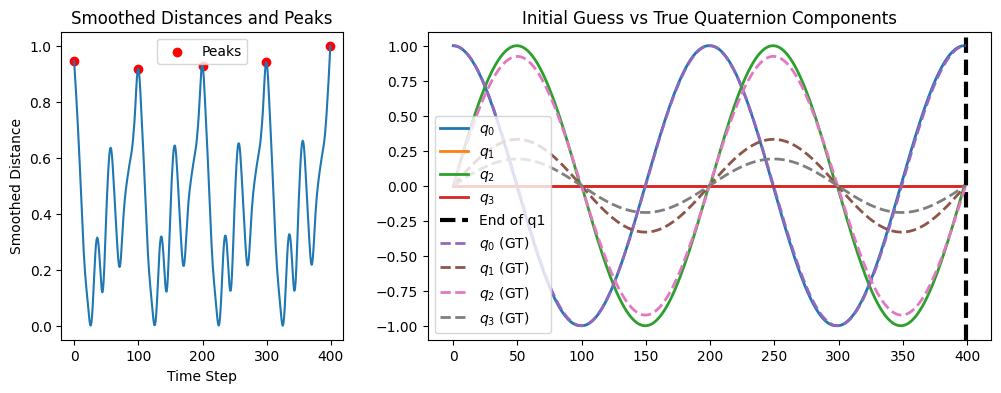

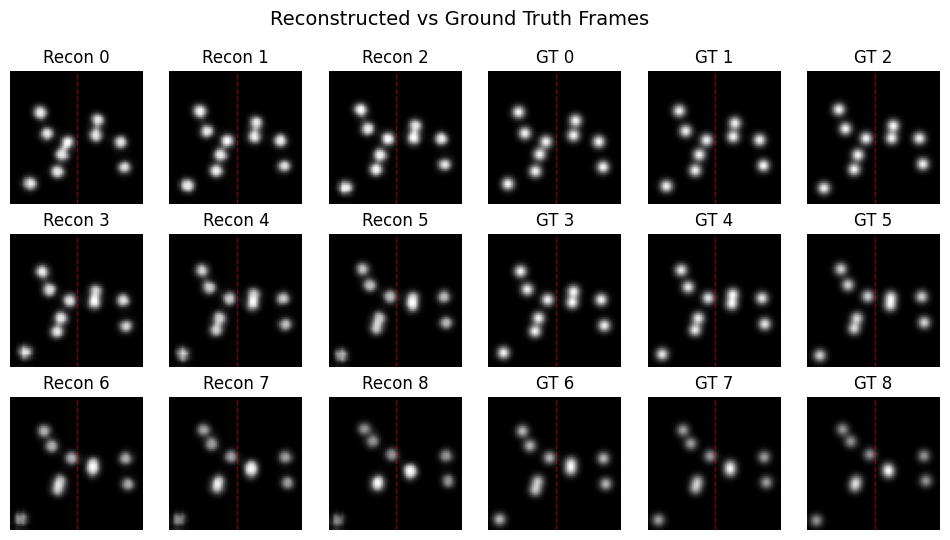

In [ ]:
tomodpdt.plotting.plots_initial(tomographic_model, gt=q_gt.to('cpu'), save_folder=save_folder)

### 3.3 - Optimize the volume alone first

The optimization process flows more effectively when an initial 3D volume is optimized first. To achieve this, the volume is optimized for a few iterations before both the volume and rotation parameters are jointly optimized. While it is possible to provide a custom initial volume to begin the optimization, in this case, we start with a fixed volume value of 1.33.

In [ ]:
N = len(tomographic_model.frames) # Number of frames
idx = torch.arange(N) # Index of frames
epochs_object_only = 100 # Number of epochs for the object only optimization
batch_size_object_only = 64 # Batch size for the object only optimization

train the model for `epochs_object_only` epochs...

c:\Users\Fredrik\miniconda3\envs\pytorchdt\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type                   ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ vae_model     │ VariationalAutoEncoder │  257 K │
│ 1 │ encoder       │ Sequential             │ 79.5 K │
│ 2 │ fc_mu         │ MultiLayerPerceptron   │ 32.8 K │
│ 3 │ imaging_model │ Sum3d2d                │      0 │
│ 4 │ train_metrics │ MetricCollection       │      0 │
│ 5 │ val_metrics   │ MetricCollection       │      0 │
│ 6 │ test_metrics  │ MetricCollection       │      0 │
│ 7 │ optimizer     │ Adam                   │      0 │
│   │ other params  │ n/a                    │  149 K │
└───┴───────────────┴────────────────────────┴────────┘

Trainable params: 262 K                                                                                            
Non-trainable params: 257 K                                                                                        
Total params: 519 K                                                                                                
Total estimated model params size (MB): 2

c:\Users\Fredrik\miniconda3\envs\pytorchdt\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training time:  0.34300138155619303  minutes


c:\Users\Fredrik\miniconda3\envs\pytorchdt\Lib\site-packages\deeplay\callbacks\history.py:151: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale(yscale)


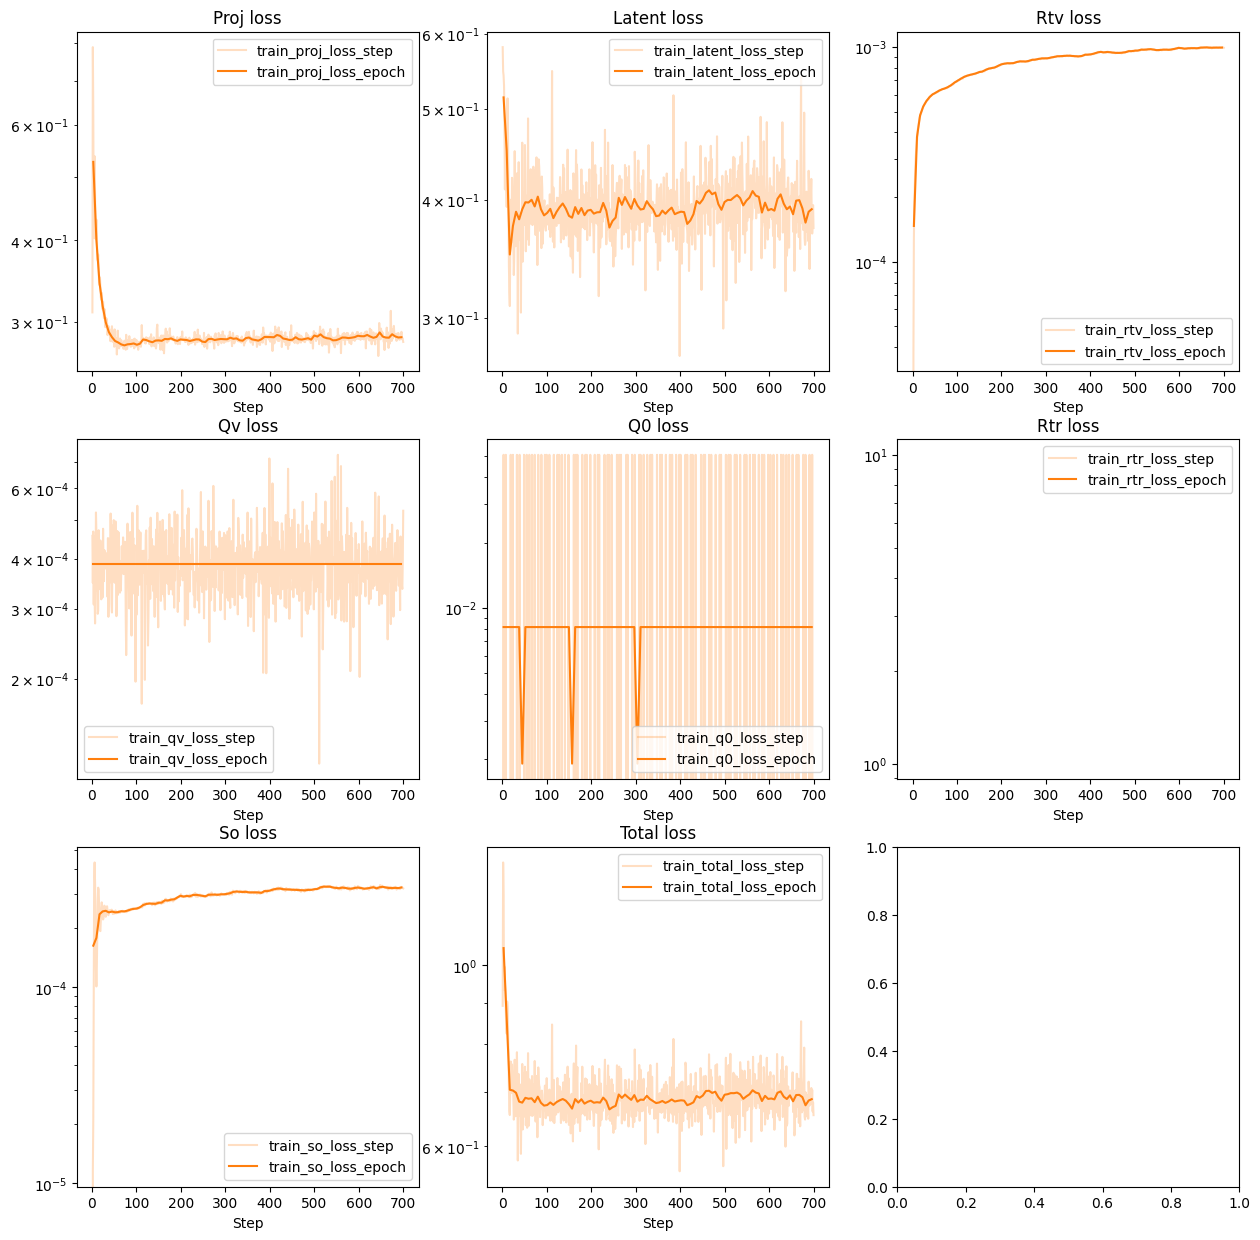

In [ ]:
# Toggle the gradients of the quaternion parameters to False
tomographic_model.toggle_gradients_quaternion(False)

# Move the model to device
tomographic_model.move_all_to_device(DEV)

# Train the model
start_time = time.time()
trainer = dl.Trainer(max_epochs=epochs_object_only, accelerator="auto", log_every_n_steps=10)
trainer.fit(tomographic_model, DataLoader(idx, batch_size=batch_size_object_only , shuffle=True))
print("Training time: ", (time.time() - start_time) / 60, " minutes")

# Plot the training history
try:
    trainer.history.plot()
except:
    print("No history to plot...")

### 3.4 - Optimize the 3D volume and the rotation parameters

This is the main optimization loop where both the 3D volume and the rotation parameters are optimized simultaneously.

In [ ]:
epochs_object_rot = 1250
batch_size_object_rot = 128

and train the model for `epochs_object_rot` epochs...

┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type                   ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ vae_model     │ VariationalAutoEncoder │  257 K │
│ 1 │ encoder       │ Sequential             │ 79.5 K │
│ 2 │ fc_mu         │ MultiLayerPerceptron   │ 32.8 K │
│ 3 │ imaging_model │ Sum3d2d                │      0 │
│ 4 │ train_metrics │ MetricCollection       │      0 │
│ 5 │ val_metrics   │ MetricCollection       │      0 │
│ 6 │ test_metrics  │ MetricCollection       │      0 │
│ 7 │ optimizer     │ Adam                   │      0 │
│   │ other params  │ n/a                    │  149 K │
└───┴───────────────┴────────────────────────┴────────┘

Trainable params: 262 K                                                                                            
Non-trainable params: 257 K                                                                                        
Total params: 519 K                                                                                                
Total estimated model params size (MB): 2

c:\Users\Fredrik\miniconda3\envs\pytorchdt\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training time:  21.129452999432882  minutes


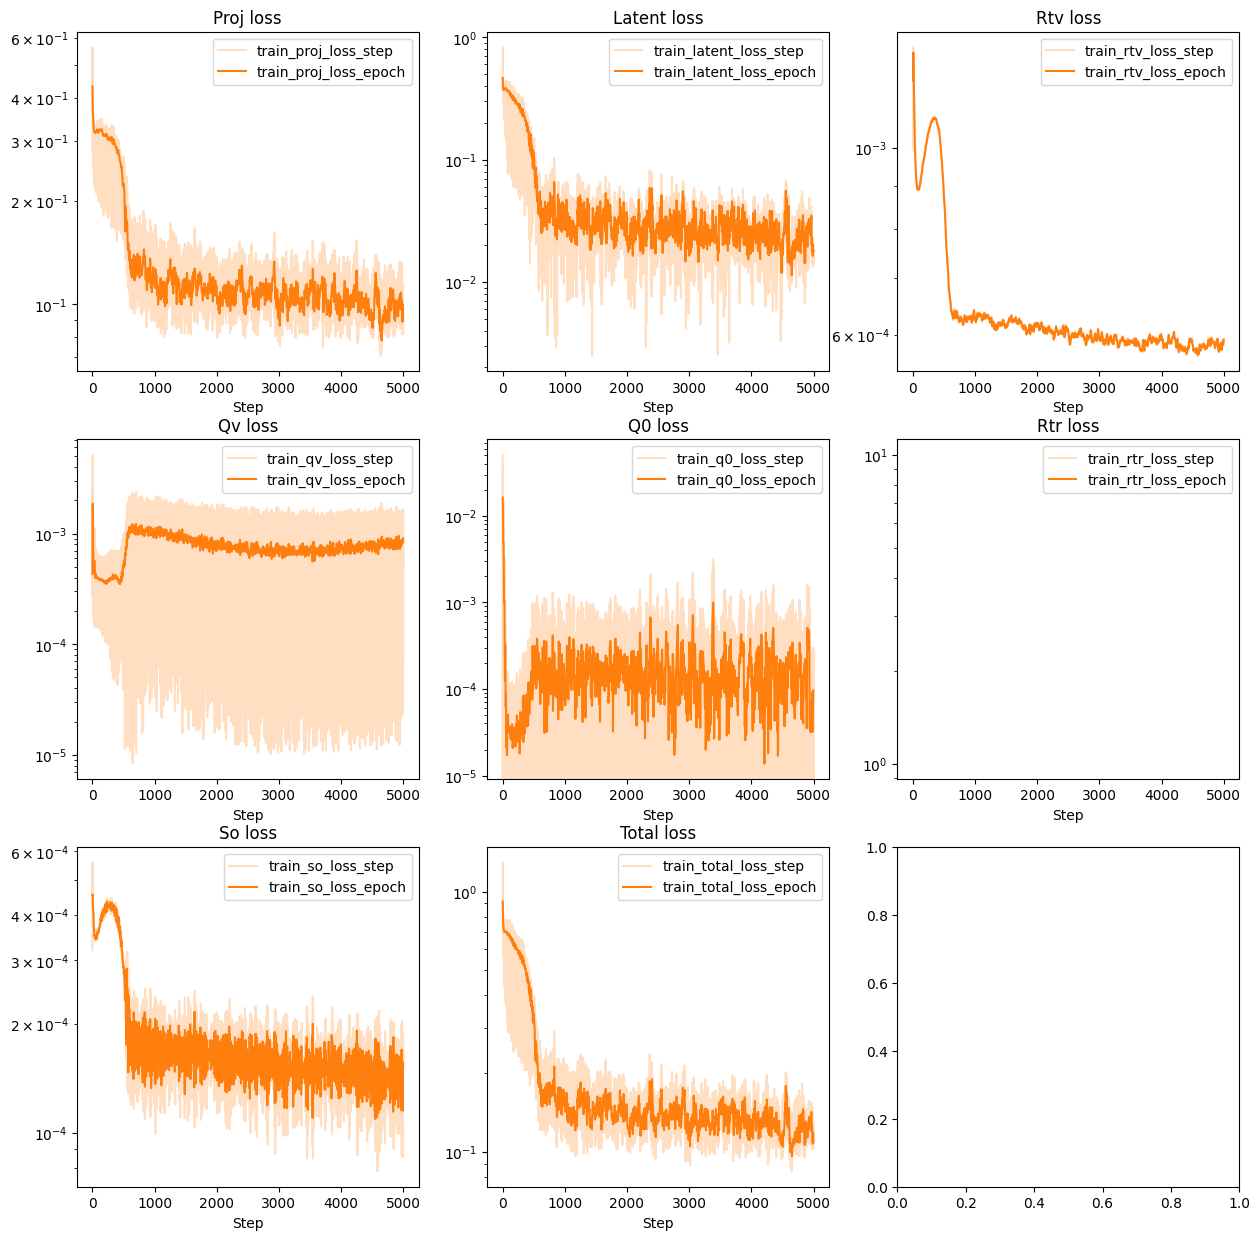

In [ ]:
# Toggle the gradients of the quaternion parameters
tomographic_model.toggle_gradients_quaternion(True)

# Move the model to device
tomographic_model.move_all_to_device(DEV)

# Train the model
start_time = time.time()
trainer = dl.Trainer(max_epochs=epochs_object_rot, accelerator="auto", log_every_n_steps=10)
trainer.fit(tomographic_model, DataLoader(idx, batch_size=batch_size_object_rot, shuffle=False))
print("Training time: ", (time.time() - start_time) / 60, " minutes")

# Plot the training history
try:
    trainer.history.plot()
except:
    print("No history to plot...")

## 4.0 - Visualize the reconstructed volume and the parameters

Finally, we visualize the reconstructed 3D volume and the rotation parameters. The reconstructed volume is displayed as a 3D volume, while the rotation parameters are represented in a 3D scatter plot.

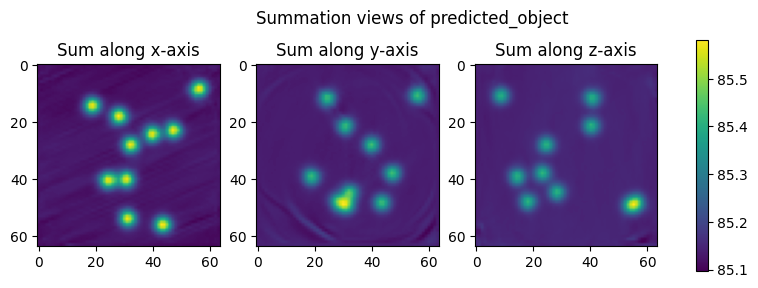

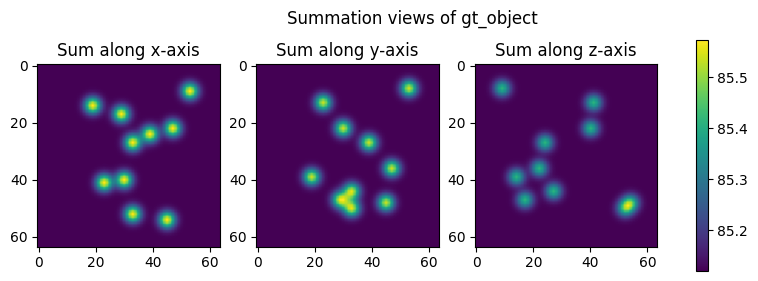

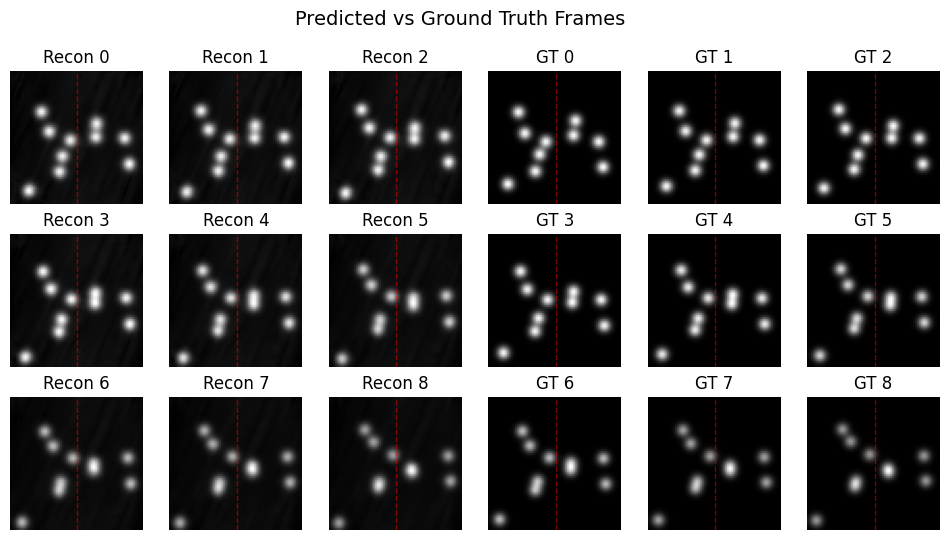

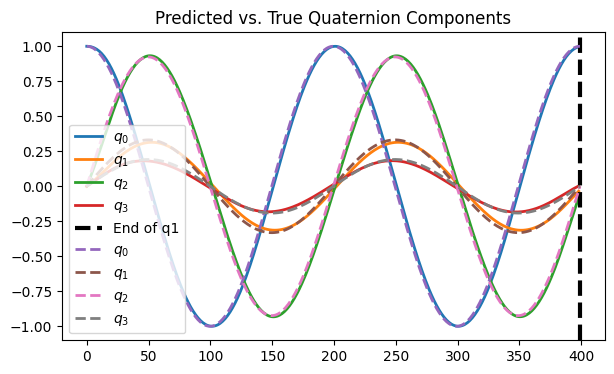

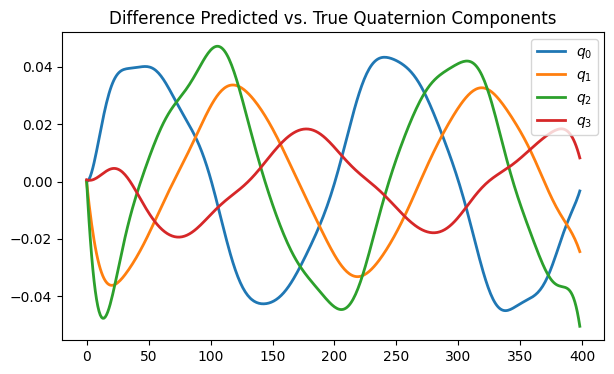

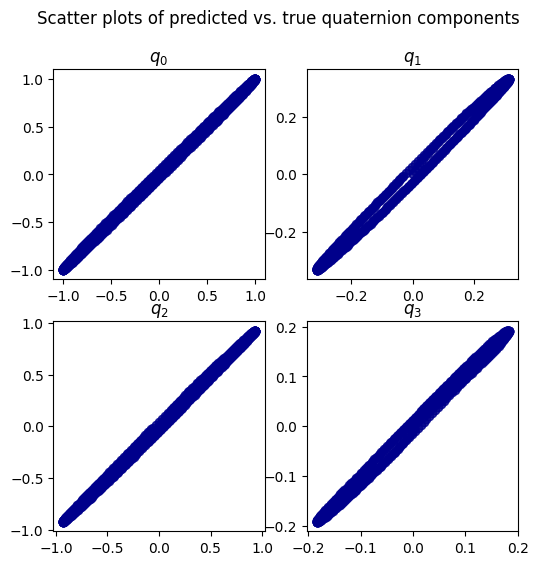

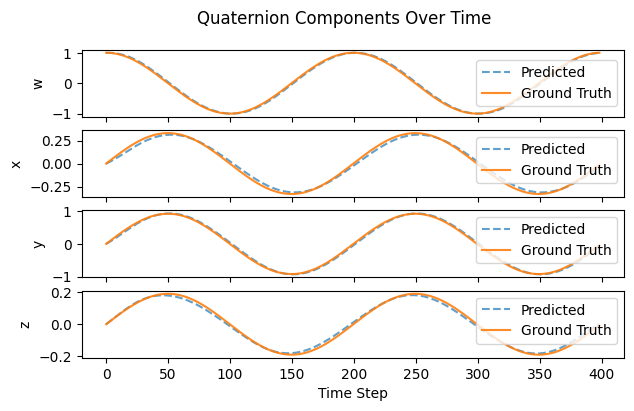

In [ ]:
# Move it to the GPU if possible for faster plotting
tomographic_model.move_all_to_device(DEV)

# Visualize the final volume and rotations.
tomodpdt.plotting.plots_optim(tomographic_model, gt_q=q_gt.to('cpu'), gt_v=test_object.to('cpu'), plot_3d=plotly_3d, save_folder=save_folder)

## 5 - Save the reconstructed volume and the parameters

Once the process is complete, we can save the reconstructed volume and the quaternion parameters to `numpy` arrays.

In [ ]:
if save_folder is not None:
    
    # save the volume as a numpy array
    np.save(f'{save_folder}/volume.npy', tomographic_model.volume.cpu().detach().numpy())

    # save the quaternions as a numpy array
    quaternions_pred = tomographic_model.get_quaternions_final().detach().cpu().numpy()
    np.save(f'{save_folder}/quaternions.npy', quaternions_pred)
